## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26.4M/26.4M [00:00<00:00, 113MB/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 4.50MB/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 62.1MB/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.5MB/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
            Linear-5                   [-1, 64]          16,448
       BatchNorm1d-6                   [-1, 64]             128
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 218,698
Trainable params: 218,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.83
Estimated Total Size (MB): 0.85
----------------------------------------------------------------


Your experiments come here:

In [9]:
def train_test(net, n_epochs, train_l, test_l, optim, criterion, threshold=1.0):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for i in range(n_epochs):
        net.train()
        losses = []
        correct = 0
        total = 0

        for j, (X_batch, y_batch) in enumerate(train_l):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            pred = net(X_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optim.step()
            optim.zero_grad()

            losses.append(loss.item())
            correct += torch.sum(torch.argmax(pred, dim=1) == y_batch)
            total += len(X_batch)

            if j % 100 == 0:
                print(f"Epoch: {i+1} / {n_epochs} Step: {j+1} / {len(train_l)} Train loss: {np.mean(np.array(losses))} Train accuracy: {correct / total}")

        train_losses.append(np.mean(np.array(losses)))
        train_accs.append(correct / total)

        net.eval()
        losses = []
        correct = 0
        total = 0

        for j, (X_batch, y_batch) in enumerate(test_l):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            pred = net(X_batch)
            loss = criterion(pred, y_batch)

            losses.append(loss.item())

            correct += torch.sum(torch.argmax(pred, dim=1) == y_batch)
            total += len(X_batch)

        print(f"Epoch: {i+1} / {n_epochs} Test loss: {np.mean(np.array(losses))} Test accuracy: {correct / total}")

        test_losses.append(np.mean(np.array(losses)))
        test_accs.append(correct / total)
        if test_accs[-1] > threshold:
            break

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [10]:
model = TinyNeuralNetwork().to(device)
optim = torch.optim.Adam(model.parameters(), lr=4e-3)
loss_func = nn.CrossEntropyLoss()
history_tiny = train_test(model, 50, train_loader, test_loader, optim, loss_func, threshold=0.885)

Epoch: 1 / 50 Step: 1 / 469 Train loss: 2.428495407104492 Train accuracy: 0.03125
Epoch: 1 / 50 Step: 101 / 469 Train loss: 0.6494935665390279 Train accuracy: 0.7847307920455933
Epoch: 1 / 50 Step: 201 / 469 Train loss: 0.545751854703201 Train accuracy: 0.8116448521614075
Epoch: 1 / 50 Step: 301 / 469 Train loss: 0.499608968777514 Train accuracy: 0.8255554437637329
Epoch: 1 / 50 Step: 401 / 469 Train loss: 0.4709467000497547 Train accuracy: 0.8340477347373962
Epoch: 1 / 50 Test loss: 0.3916393704712391 Test accuracy: 0.8562999963760376
Epoch: 2 / 50 Step: 1 / 469 Train loss: 0.3274158537387848 Train accuracy: 0.890625
Epoch: 2 / 50 Step: 101 / 469 Train loss: 0.33287742438882884 Train accuracy: 0.877397894859314
Epoch: 2 / 50 Step: 201 / 469 Train loss: 0.33724657902077065 Train accuracy: 0.8751165866851807
Epoch: 2 / 50 Step: 301 / 469 Train loss: 0.3390868682896972 Train accuracy: 0.8754411935806274
Epoch: 2 / 50 Step: 401 / 469 Train loss: 0.33768522516450383 Train accuracy: 0.87581

In [61]:
def plot_history(history, label):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    X_range = range(len(history['train_losses']))

    axs[0].plot(X_range, history['train_losses'], label='train loss')
    axs[0].plot(X_range, history['test_losses'], label='test loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(X_range, np.array([history['train_accs'][i].cpu().numpy() for i in range(len(history['train_accs']))]), label='train accuracy')
    axs[1].plot(X_range, np.array([history['test_accs'][i].cpu().numpy() for i in range(len(history['test_accs']))]), label='test accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()


    fig.suptitle(label)
    fig.show()

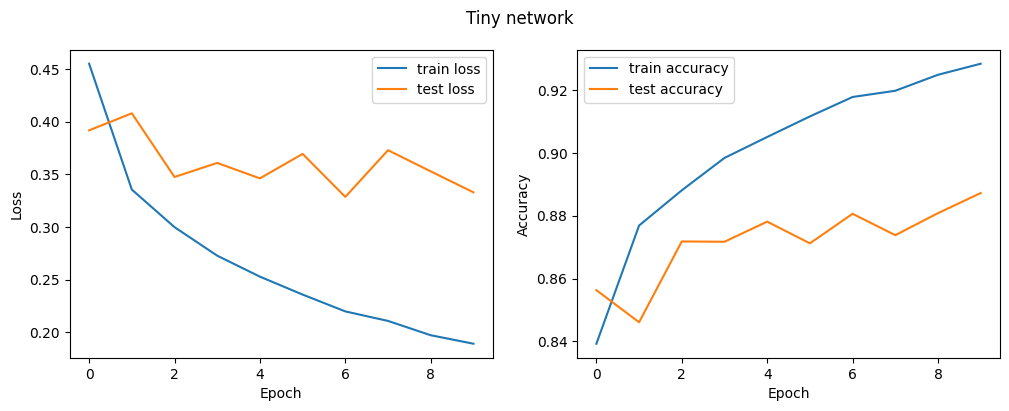

In [77]:
plot_history(history_tiny, 'Tiny network')

In [79]:
max(history_tiny['test_accs'])

tensor(0.8872, device='cuda:0')

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [70]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),


            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [71]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                 [-1, 2048]       1,050,624
              ReLU-7                 [-1, 2048]               0
            Linear-8                  [-1, 512]       1,049,088
              ReLU-9                  [-1, 512]               0
           Linear-10                  [-1, 256]         131,328
             ReLU-11                  [-1, 256]               0
           Linear-12                  [-1, 128]          32,896
             ReLU-13                  [-1, 128]               0
           Linear-14                   

In [72]:
from numpy.random import default_rng

rng = default_rng()
numbers = rng.choice(60000, size=10000, replace=False)
trainset_reduced = torch.utils.data.Subset(fmnist_dataset_train, numbers)
train_loader_reduced = torch.utils.data.DataLoader(trainset_reduced,
                                                   batch_size=128,
                                                   shuffle=True,
                                                   num_workers=2)

In [73]:
model = OverfittingNeuralNetwork().to(device)
optim = torch.optim.Adam(model.parameters(), lr=4e-3)
loss_func = nn.CrossEntropyLoss()
history_overfitting = train_test(model, 30, train_loader_reduced, test_loader, optim, loss_func)

Epoch: 1 / 30 Step: 1 / 79 Train loss: 2.2993898391723633 Train accuracy: 0.109375
Epoch: 1 / 30 Test loss: 0.9501050874590874 Test accuracy: 0.5853999853134155
Epoch: 2 / 30 Step: 1 / 79 Train loss: 1.1038748025894165 Train accuracy: 0.5703125
Epoch: 2 / 30 Test loss: 0.6938032656908035 Test accuracy: 0.755299985408783
Epoch: 3 / 30 Step: 1 / 79 Train loss: 0.5738387107849121 Train accuracy: 0.7734375
Epoch: 3 / 30 Test loss: 0.5996203720569611 Test accuracy: 0.7737999558448792
Epoch: 4 / 30 Step: 1 / 79 Train loss: 0.4609995186328888 Train accuracy: 0.8046875
Epoch: 4 / 30 Test loss: 0.5803345091640949 Test accuracy: 0.7926999926567078
Epoch: 5 / 30 Step: 1 / 79 Train loss: 0.5248367786407471 Train accuracy: 0.8203125
Epoch: 5 / 30 Test loss: 0.5722431130707264 Test accuracy: 0.8009999990463257
Epoch: 6 / 30 Step: 1 / 79 Train loss: 0.6265251636505127 Train accuracy: 0.7578125
Epoch: 6 / 30 Test loss: 0.4938152275979519 Test accuracy: 0.8202999830245972
Epoch: 7 / 30 Step: 1 / 79 Tra

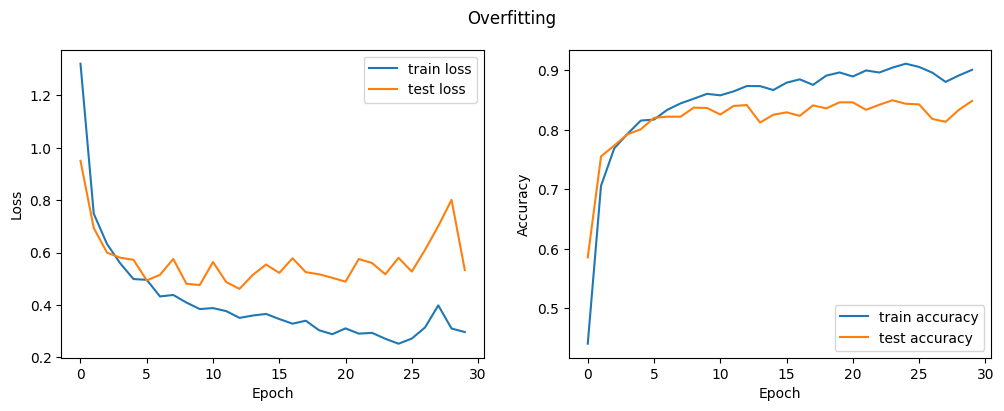

In [76]:
plot_history(history_overfitting, 'Overfitting')

In [75]:
max(history_overfitting['test_accs'])

tensor(0.8499, device='cuda:0')

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [80]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [81]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                  [-1, 512]         524,800
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                 [-1, 2048]       1,050,624
      BatchNorm1d-11                 [-1, 2048]           4,096
             ReLU-12                 [-1, 2048]               0
          Dropout-13                 [-1, 2048]               0
           Linear-14                  [

In [83]:
model = FixedNeuralNetwork().to(device)
optim = torch.optim.Adam(model.parameters(), lr=4e-3)
loss_func = nn.CrossEntropyLoss()
history_fixed = train_test(model, 30, train_loader_reduced, test_loader, optim, loss_func)

Epoch: 1 / 30 Step: 1 / 79 Train loss: 2.466771364212036 Train accuracy: 0.078125
Epoch: 1 / 30 Test loss: 0.6411170355975628 Test accuracy: 0.7450999617576599
Epoch: 2 / 30 Step: 1 / 79 Train loss: 0.6697407364845276 Train accuracy: 0.765625
Epoch: 2 / 30 Test loss: 0.6054721839725972 Test accuracy: 0.7754999995231628
Epoch: 3 / 30 Step: 1 / 79 Train loss: 0.6275001764297485 Train accuracy: 0.78125
Epoch: 3 / 30 Test loss: 0.5262600503861904 Test accuracy: 0.802299976348877
Epoch: 4 / 30 Step: 1 / 79 Train loss: 0.6600052118301392 Train accuracy: 0.7578125
Epoch: 4 / 30 Test loss: 0.5492014326155186 Test accuracy: 0.7982999682426453
Epoch: 5 / 30 Step: 1 / 79 Train loss: 0.5103190541267395 Train accuracy: 0.8125
Epoch: 5 / 30 Test loss: 0.4932240918278694 Test accuracy: 0.8229999542236328
Epoch: 6 / 30 Step: 1 / 79 Train loss: 0.44808343052864075 Train accuracy: 0.8359375
Epoch: 6 / 30 Test loss: 0.5243177216500043 Test accuracy: 0.8034999966621399
Epoch: 7 / 30 Step: 1 / 79 Train los

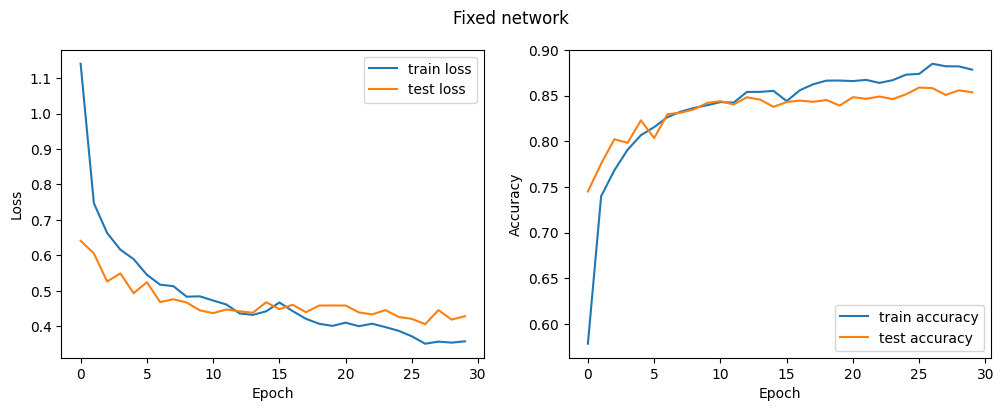

In [86]:
plot_history(history_fixed, 'Fixed network')

In [85]:
max(history_fixed['test_accs'])

tensor(0.8588, device='cuda:0')

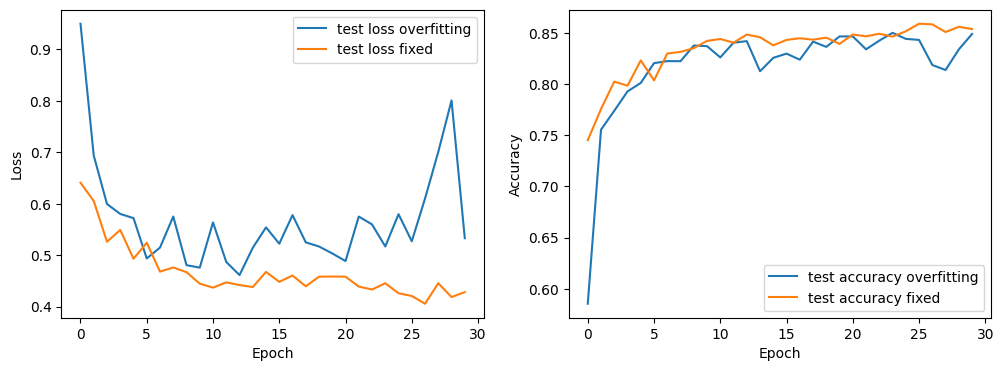

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

X_range = range(len(history_overfitting['test_losses']))

axs[0].plot(X_range, history_overfitting['test_losses'], label='test loss overfitting')
axs[0].plot(X_range, history_fixed['test_losses'], label='test loss fixed')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(X_range,  np.array([history_overfitting['test_accs'][i].cpu().numpy() for i in range(len(history_overfitting['test_accs']))]), label='test accuracy overfitting')
axs[1].plot(X_range, np.array([history_fixed['test_accs'][i].cpu().numpy() for i in range(len(history_fixed['test_accs']))]), label='test accuracy fixed')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

fig.show()

### Conclusions:
К overfitting привело то, что в модели было использовано много однитипных слоев с уменьшением размерности, модель тем самым обучалась предсказывать какие-то детали train выборки, в то время как в test выборке их не было, и ошибка начала расти. Этот эффект усугубляется большим количеством эпох обучения. Переобучения можно избежать, использовав регурялизацию, т.к. она ввобдит штраф за большое количетсво ненужных признаков. На последнем графике видно, что при переобучении значение loss-а и точности сильно колеблется, и есть тренд к росту loss-а, а введенине регурялизации это исправляет.